In [3]:
import itk

In [154]:
import numpy as np
def loadFile(name):
    imageType = itk.Image[itk.F, 3]
    
    readerType = itk.ImageFileReader[imageType]
    
    reader = readerType.New()
    
    reader.SetFileName(name)
    
    im = reader.GetOutput()
    
    reader.Update()
    return np.array(itk.PyBuffer[imageType].GetArrayFromImage(im))
    
ct = loadFile("C:/Users/hasti/AppData/Local/Temp/Slicer/RemoteIO/CT-chest.nrrd")
horizSpace = .762
vertSpace = 2.5

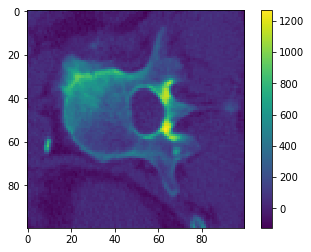

In [209]:
i = np.linspace(0, 100, 100)
j = np.linspace(-50, 50, 100)
i, j = np.meshgrid(i, j)
from scipy.interpolate import interpn

def sample(height, theta, horizoffset, depthoffset):
    midline = 200 + horizoffset
    depth = 200 + depthoffset
    
    points = [np.arange(N) for N in ct.shape]
    
    xi = ((height + j * np.sin(theta) ) / vertSpace, (i + depth) / horizSpace, (midline + j *np.cos(theta)) /horizSpace )
    xi = np.array([x.flatten() for x in xi]).transpose()
    return interpn(points, ct, xi).reshape((100, 100))
    
    
    
    
plt.imshow(sample(50, np.pi / 70, 0, 10))
plt.colorbar()
plt.show()

In [187]:
import keras

Using TensorFlow backend.


In [189]:
np.random.uniform(-1, 1, 10000)

array([ 0.96924055, -0.8489958 , -0.15060046, ...,  0.76385571,
        0.48968112,  0.43433554])

In [287]:

def makeData(N):

    angle = np.random.uniform(-np.pi / 4, np.pi / 4, N)
    hoffset = np.random.uniform(-10, 10, N)
    voffset = np.random.uniform(-10, 10, N)
    height = np.random.uniform(60, 300, N)
    data = np.array([
        sample(height[i], angle[i], voffset[i], hoffset[i]) for i in range(N)
    ])
    return data, angle.reshape(-1, 1)
data, classes = makeData(10000)
td, tc = makeData(100)


array([-0.34255759])

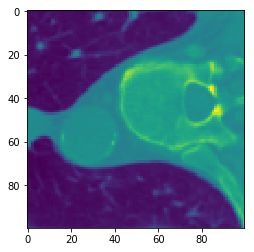

In [234]:
plt.imshow(data[1020])
classes[1020]

In [276]:
from keras.models import Sequential
model = Sequential()

In [277]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [278]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='tanh'))

In [279]:
np.max(classes)

0.78520670478976773

In [280]:
model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.sgd())

In [288]:
model.fit(data.reshape((10000, 100, 100, 1)) / 1000, classes,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(td.reshape((100, 100, 100, 1)) / 1000, tc))

Train on 10000 samples, validate on 100 samples
Epoch 1/10
10000/10000 [==============================] - 15s - loss: 0.0604 - val_loss: 0.0544
Epoch 2/10
10000/10000 [==============================] - 15s - loss: 0.0546 - val_loss: 0.0457
Epoch 3/10
10000/10000 [==============================] - 15s - loss: 0.0511 - val_loss: 0.0591
Epoch 4/10
10000/10000 [==============================] - 15s - loss: 0.0478 - val_loss: 0.0448
Epoch 5/10
10000/10000 [==============================] - 15s - loss: 0.0450 - val_loss: 0.0410
Epoch 6/10
10000/10000 [==============================] - 15s - loss: 0.0426 - val_loss: 0.0338
Epoch 7/10
10000/10000 [==============================] - 15s - loss: 0.0407 - val_loss: 0.0381
Epoch 8/10
10000/10000 [==============================] - 15s - loss: 0.0385 - val_loss: 0.0357
Epoch 9/10
10000/10000 [==============================] - 15s - loss: 0.0375 - val_loss: 0.0398
Epoch 10/10
10000/10000 [==============================] - 15s - loss: 0.0357 - val_loss

In [285]:
model.predict(td.reshape((100, 100, 100, 1)) / 1000)

array([[-0.48050874],
       [-0.34565291],
       [-0.73143947],
       [-0.1760354 ],
       [-0.67653775],
       [-0.00619632],
       [ 0.18961422],
       [ 0.46564984],
       [ 0.60679591],
       [-0.30350775],
       [-0.24983987],
       [-0.04868303],
       [ 0.23377416],
       [ 0.1694656 ],
       [ 0.09522272],
       [ 0.05624355],
       [-0.10477504],
       [ 0.60335159],
       [ 0.66907853],
       [-0.62094581],
       [-0.61414742],
       [-0.13778204],
       [-0.17912069],
       [-0.2889964 ],
       [-0.0497398 ],
       [-0.15924038],
       [-0.16439138],
       [ 0.55116773],
       [-0.05354499],
       [ 0.1245654 ],
       [ 0.65157837],
       [-0.38570642],
       [ 0.59280682],
       [-0.42252561],
       [-0.59102869],
       [ 0.11212034],
       [-0.79888803],
       [-0.27951023],
       [ 0.34376928],
       [-0.18523072],
       [ 0.10142335],
       [-0.00310488],
       [-0.33839074],
       [-0.59967422],
       [ 0.32111868],
       [-0

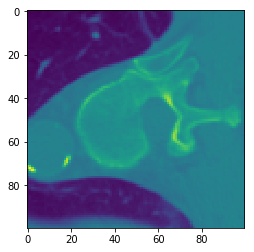

In [272]:
plt.imshow(td.reshape((100, 100, 100, 1))[1][:, :, 0])
plt.show()

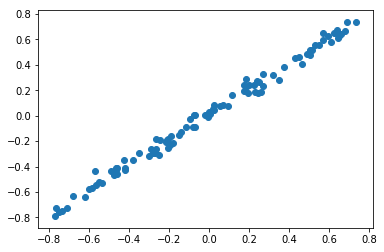

In [289]:
plt.scatter(tc.flatten(), model.predict(td.reshape((100, 100, 100, 1)) / 1000).flatten())